In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 515, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 515 (delta 139), reused 126 (delta 122), pack-reused 354
Receiving objects: 100% (515/515), 28.61 MiB | 22.37 MiB/s, done.
Resolving deltas: 100% (246/246), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [2]:
#!pip install --upgrade transformers


In [3]:
# hide
from utils import *
setup_chapter()

Using transformers v4.11.3
Using datasets v1.16.1


# Making Transformers Efficient in Production

<img alt="Scaling BERT at Roblox" caption="How Roblox scaled BERT with knowledge distillation, dynamic padding, and weight quantization (photo courtesy of Roblox employees Quoc N. Le and Kip Kaehler)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_roblox.png?raw=1" id="roblox"/>

## Intent Detection as a Case Study

<img alt="Out of Scope Query" width="400" caption="Three exchanges between a human (right) and a text-based assistant (left) for personal finance (courtesy of Stefan Larson et al.)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_oos.png?raw=1" id="oos"/> 

In [4]:
#hide_output
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

Downloading:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in 
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

## Creating a Performance Benchmark

In [6]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self):
        # We'll define this later
        pass    

    def compute_size(self):
        # We'll define this later
        pass

    def time_pipeline(self):
        # We'll define this later
        pass
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [7]:
#hide_output
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

Downloading:   0%|          | 0.00/2.75k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset clinc_oos downloaded and prepared to /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [9]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [10]:
#hide_output
from datasets import load_metric 

accuracy_score = load_metric("accuracy")

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [11]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [12]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [13]:
import torch
from pathlib import Path

def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [14]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 81.607
Latency (ms) - 76.407
Latency (ms) - 80.084


In [15]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [16]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15
Average latency (ms) - 71.36 +\- 17.91
Accuracy on test set - 0.867


## Making Models Smaller via Knowledge Distillation

### Knowledge Distillation for Fine-Tuning

<img alt="Soft Probabilities" caption="Comparison of a hard label that is one-hot encoded (left), softmax probabilities (middle), and softened class probabilities (right)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_soft-probs.png?raw=1" id="soft-probs"/> 

<img alt="Knowledge distillation" caption="The knowledge distillation process" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_kd.png?raw=1" id="kd"/> 

### Knowledge Distillation for Pretraining

### Creating a Knowledge Distillation Trainer

In [17]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [18]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

### Choosing a Good Student Initialization

In [19]:
#hide_output
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [20]:
from huggingface_hub import notebook_login

notebook_login()

In [21]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [22]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch", 
    num_train_epochs=5, learning_rate=2e-5, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01, 
    push_to_hub=True)

In [23]:
#hide
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
student_training_args.log_level = 40

In [24]:
#hide
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [25]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [26]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels, 
                                   id2label=id2label, label2id=label2id))

In [27]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [28]:
#hide_output
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [29]:
from huggingface_hub import notebook_login
notebook_login()

In [31]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

Cloning https://huggingface.co/khadija267/distilbert-base-uncased-finetuned-clinc into local empty directory.


Download file pytorch_model.bin:   0%|          | 15.4k/256M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 2.87k/2.87k [00:00<?, ?B/s]

Download file runs/Apr25_23-43-14_872d2340b0ad/events.out.tfevents.1682466385.872d2340b0ad.2403.0: 100%|######…

Clean file training_args.bin:  35%|###4      | 1.00k/2.87k [00:00<?, ?B/s]

Clean file runs/Apr25_23-43-14_872d2340b0ad/events.out.tfevents.1682466385.872d2340b0ad.2403.0:   8%|7        …

Download file runs/Apr25_23-43-14_872d2340b0ad/1682466385.2668533/events.out.tfevents.1682466385.872d2340b0ad.…

Clean file runs/Apr25_23-43-14_872d2340b0ad/1682466385.2668533/events.out.tfevents.1682466385.872d2340b0ad.240…

Clean file pytorch_model.bin:   0%|          | 1.00k/256M [00:00<?, ?B/s]

TrainOutput(global_step=1590, training_loss=2.051459504973214, metrics={'train_runtime': 108.0851, 'train_samples_per_second': 705.463, 'train_steps_per_second': 14.711, 'total_flos': 413896353421488.0, 'train_loss': 2.051459504973214, 'epoch': 5.0})

In [32]:
#hide_output
distilbert_trainer.push_to_hub("Training completed!")

Upload file pytorch_model.bin:   0%|          | 1.00/256M [00:00<?, ?B/s]

Upload file runs/Apr26_19-56-19_d315fcee2e02/events.out.tfevents.1682539232.d315fcee2e02.2567.0:   0%|        …

Upload file training_args.bin:   0%|          | 1.00/2.87k [00:00<?, ?B/s]

Upload file runs/Apr26_19-56-19_d315fcee2e02/1682539232.553481/events.out.tfevents.1682539232.d315fcee2e02.256…

To https://huggingface.co/khadija267/distilbert-base-uncased-finetuned-clinc
   a055893..5dbda75  main -> main

   a055893..5dbda75  main -> main

To https://huggingface.co/khadija267/distilbert-base-uncased-finetuned-clinc
   5dbda75..b018ef2  main -> main

   5dbda75..b018ef2  main -> main



'https://huggingface.co/khadija267/distilbert-base-uncased-finetuned-clinc/commit/5dbda75da5d85e1f446f21adf0a37b70bde1c080'

In [33]:
#hide_output
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

Downloading:   0%|          | 0.00/8.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [34]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 26.35 +\- 1.73
Accuracy on test set - 0.858


<ipython-input-35-c79dc0677c6c>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


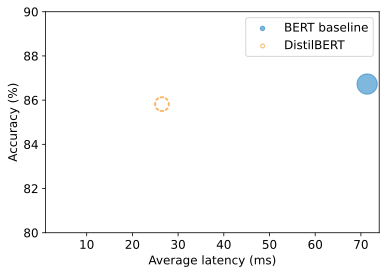

In [35]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
    
plot_metrics(perf_metrics, optim_type)

### Finding Good Hyperparameters with Optuna

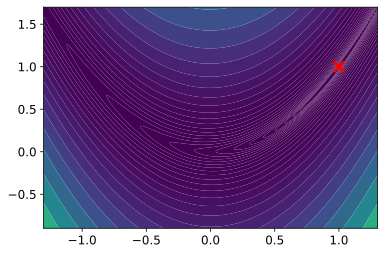

In [36]:
#hide_input
#id banana-function
#alt A banana plot
#caption Plot of the Rosenbrock function of two variables 
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2
    
X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [37]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [38]:
#hide_output
import optuna 

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2023-04-26 20:05:36,515] A new study created in memory with name: no-name-ec4f975a-2904-4a21-8107-9f273b83940c
[I 2023-04-26 20:05:36,519] Trial 0 finished with value: 56.12239073373939 and parameters: {'x': 0.16592775501672286, 'y': 0.7720232167696341}. Best is trial 0 with value: 56.12239073373939.
[I 2023-04-26 20:05:36,522] Trial 1 finished with value: 81.12087044060917 and parameters: {'x': 0.9107259586422467, 'y': -0.07120523532384082}. Best is trial 0 with value: 56.12239073373939.
[I 2023-04-26 20:05:36,524] Trial 2 finished with value: 100.0190666844806 and parameters: {'x': -0.3389667558582885, 'y': 1.105989954382812}. Best is trial 0 with value: 56.12239073373939.
[I 2023-04-26 20:05:36,527] Trial 3 finished with value: 1198.325923224706 and parameters: {'x': 1.9612861427511326, 'y': 0.3862938540325098}. Best is trial 0 with value: 56.12239073373939.
[I 2023-04-26 20:05:36,529] Trial 4 finished with value: 26.25180250941169 and parameters: {'x': -1.0993091389027279, 'y': 

In [39]:
study.best_params

{'x': 1.0160342305296164, 'y': 1.0329301814693264}

In [40]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [42]:
#hide_output
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)

[I 2023-04-26 20:11:07,251] A new study created in memory with name: no-name-457b8a73-910d-4710-bfba-a63f1335275b


[I 2023-04-26 20:14:41,008] Trial 0 finished with value: 0.9287096774193548 and parameters: {'num_train_epochs': 10, 'alpha': 0.8964305814207517, 'temperature': 6}. Best is trial 0 with value: 0.9287096774193548.


[I 2023-04-26 20:16:49,014] Trial 1 finished with value: 0.9064516129032258 and parameters: {'num_train_epochs': 6, 'alpha': 0.04836971950221991, 'temperature': 9}. Best is trial 0 with value: 0.9287096774193548.


[I 2023-04-26 20:20:21,631] Trial 2 finished with value: 0.9287096774193548 and parameters: {'num_train_epochs': 10, 'alpha': 0.2471784887701367, 'temperature': 11}. Best is trial 0 with value: 0.9287096774193548.


In [43]:
print(best_run)

BestRun(run_id='0', objective=0.9287096774193548,
hyperparameters={'num_train_epochs': 10, 'alpha': 0.8964305814207517,
'temperature': 6})


In [44]:
#hide_output
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)
    
# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

Cloning https://huggingface.co/khadija267/distilbert-base-uncased-distilled-clinc into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.40k/256M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 2.93k/2.93k [00:00<?, ?B/s]

Clean file training_args.bin:  34%|###4      | 1.00k/2.93k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/256M [00:00<?, ?B/s]

In [45]:
#hide_output
distil_trainer.push_to_hub("Training complete")

Upload file pytorch_model.bin:   0%|          | 1.00/256M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/2.93k [00:00<?, ?B/s]

To https://huggingface.co/khadija267/distilbert-base-uncased-distilled-clinc
   b67437e..b507be8  main -> main

   b67437e..b507be8  main -> main

To https://huggingface.co/khadija267/distilbert-base-uncased-distilled-clinc
   b507be8..e1430e4  main -> main

   b507be8..e1430e4  main -> main



'https://huggingface.co/khadija267/distilbert-base-uncased-distilled-clinc/commit/b507be8bbedbec66ed86a029e3cdfe5b8a9de664'

### Benchmarking Our Distilled Model

In [46]:
distilled_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Downloading:   0%|          | 0.00/8.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Model size (MB) - 255.88
Average latency (ms) - 26.62 +\- 2.07
Accuracy on test set - 0.868


<ipython-input-35-c79dc0677c6c>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


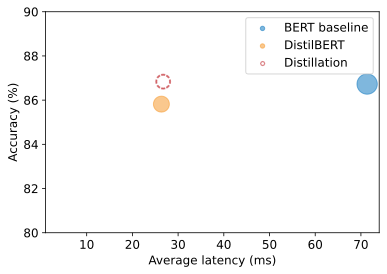

In [47]:
plot_metrics(perf_metrics, optim_type)

## Making Models Faster with Quantization

### Sidebar: A Primer on Floating-Point and Fixed-Point Numbers

### End sidebar

<img alt="Mapping floating-point numbers to 8-bit integers" width="800" caption="Quantizing floating-point numbers as unsigned 8-bit integers (courtesy of Manas Sahni)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_fp32-to-int8.png?raw=1" id="fp32toint8"/>

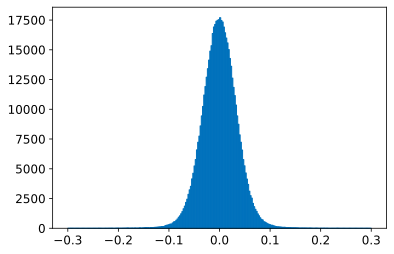

In [48]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [49]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [50]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

In [51]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], dtype=torch.int8)

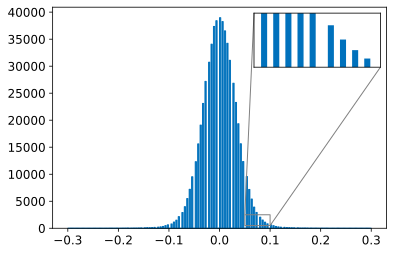

In [52]:
#hide_input
#id weight-quantization
#alt Effect of quantization on a transformer's weights
#caption Effect of quantization on a transformer's weights
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# Create histogram
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# Create zoom inset
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [53]:
%%timeit 
weights @ weights

6.75 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [55]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

242 µs ± 3.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [56]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

<ipython-input-56-600687c2638a>:3: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


3.999755879241598

In [57]:
#hide_output
from torch.quantization import quantize_dynamic

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

### Benchmarking Our Quantized Model

In [58]:
pipe = pipeline("text-classification", model=model_quantized, 
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 17.76 +\- 1.13
Accuracy on test set - 0.876


<ipython-input-35-c79dc0677c6c>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


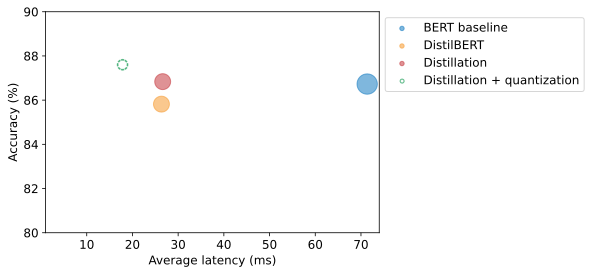

In [59]:
plot_metrics(perf_metrics, optim_type)

## Optimizing Inference with ONNX and the ONNX Runtime

<img alt="Example ONNX graph" width="500" caption="A section of the ONNX graph for BERT-base, visualized in Netron" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_bert-onnx.png?raw=1" id="bert-onnx"/>

<img alt="Architecture of the ONNX and ONNX Runtime ecosystem" width="500" caption="Architecture of the ONNX and ONNX Runtime ecosystem (courtesy of the ONNX Runtime team)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_onnx-ort.png?raw=1" id="onnx-ort"/>

In [60]:
#hide_output

import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

Convering to ONNX is not supported 

In [95]:
'''
#https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-convert-model
import torch.onnx 

#Function to Convert to ONNX 
def Convert_ONNX(): 

    # set the model to inference mode 
    model.eval() 

    # Let's create a dummy input tensor  
    dummy_input = torch.randn(1, input_size, requires_grad=True)  

    # Export the model   
    torch.onnx.export(model,         # model being run 
         dummy_input,       # model input (or a tuple for multiple inputs) 
         "ImageClassifier.onnx",       # where to save the model  
         export_params=True,  # store the trained parameter weights inside the model file 
         opset_version=10,    # the ONNX version to export the model to 
         do_constant_folding=True,  # whether to execute constant folding for optimization 
         input_names = ['modelInput'],   # the model's input names 
         output_names = ['modelOutput'], # the model's output names 
         dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes 
                                'modelOutput' : {0 : 'batch_size'}}) 
    print(" ") 
    print('Model has been converted to ONNX')

model = "transformersbook/distilbert-base-uncased-distilled-clinc"
path =  Path("onnx/model.onnx")
model.load_state_dict(torch.load(path)) 

# Test with batch of images 
#testBatch() 
# Test how the classes performed 
#testClassess() 

# Conversion to ONNX 
Convert_ONNX() 
'''

'\n#https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-convert-model\nimport torch.onnx \n\n#Function to Convert to ONNX \ndef Convert_ONNX(): \n\n    # set the model to inference mode \n    model.eval() \n\n    # Let\'s create a dummy input tensor  \n    dummy_input = torch.randn(1, input_size, requires_grad=True)  \n\n    # Export the model   \n    torch.onnx.export(model,         # model being run \n         dummy_input,       # model input (or a tuple for multiple inputs) \n         "ImageClassifier.onnx",       # where to save the model  \n         export_params=True,  # store the trained parameter weights inside the model file \n         opset_version=10,    # the ONNX version to export the model to \n         do_constant_folding=True,  # whether to execute constant folding for optimization \n         input_names = [\'modelInput\'],   # the model\'s input names \n         output_names = [\'modelOutput\'], # the model\'s output names \n         dynamic_axes=

In [94]:
'''
#hide_output
from transformers.convert_graph_to_onnx import convert


model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer, 
        output=onnx_model_path, opset=12, pipeline_name="text-classification", use_external_data_format=True)
'''

'\n#hide_output\nfrom transformers.convert_graph_to_onnx import convert\n\n\nmodel_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"\nonnx_model_path = Path("onnx/model.onnx")\nconvert(framework="pt", model=model_ckpt, tokenizer=tokenizer, \n        output=onnx_model_path, opset=12, pipeline_name="text-classification", use_external_data_format=True)\n'

In [64]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, 
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"): 
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [93]:
'''
onnx_model = create_model_for_provider(onnx_model_path)
'''

'\nonnx_model = create_model_for_provider(onnx_model_path)\n'

In [92]:
'''
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape
'''

'\ninputs = clinc_enc["test"][:1]\ndel inputs["labels"]\nlogits_onnx = onnx_model.run(None, inputs)[0]\nlogits_onnx.shape\n'

In [91]:
'''
np.argmax(logits_onnx)
'''

'\nnp.argmax(logits_onnx)\n'

In [76]:
clinc_enc["test"][0]["labels"]

61

In [77]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy() 
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [90]:
'''
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)
'''

'\npipe = OnnxPipeline(onnx_model, tokenizer)\npipe(query)\n'

In [79]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
        
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [89]:
'''
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())
'''

'\noptim_type = "Distillation + ORT"\npb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,\n                              model_path="onnx/model.onnx")\nperf_metrics.update(pb.run_benchmark())\n'

<ipython-input-35-c79dc0677c6c>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


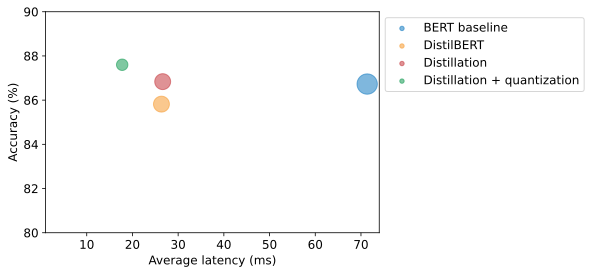

In [81]:
plot_metrics(perf_metrics, optim_type)

In [87]:
'''
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)
'''

'\nfrom onnxruntime.quantization import quantize_dynamic, QuantType\n\nmodel_input = "onnx/model.onnx"\nmodel_output = "onnx/model.quant.onnx"\nquantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)\n'

In [88]:
'''
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, 
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())
'''

'\nonnx_quantized_model = create_model_for_provider(model_output)\npipe = OnnxPipeline(onnx_quantized_model, tokenizer)\noptim_type = "Distillation + ORT (quantized)"\npb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, \n                              model_path=model_output)\nperf_metrics.update(pb.run_benchmark())\n'

<ipython-input-35-c79dc0677c6c>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


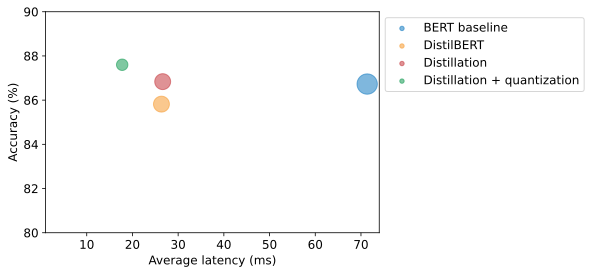

In [84]:
plot_metrics(perf_metrics, optim_type)

## Making Models Sparser with Weight Pruning

### Sparsity in Deep Neural Networks

<img alt="Network Pruning" width="500" caption="Weights and neurons before and after pruning (courtesy of Song Han)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_network-pruning.png?raw=1" id="network-pruning"/> 

### Weight Pruning Methods

#### Magnitude pruning

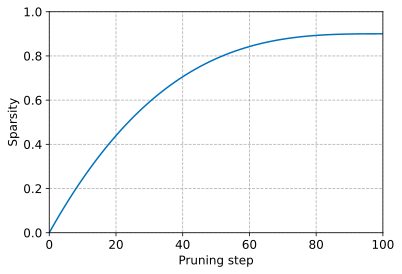

In [85]:
#hide_input
#id sparsity-scheduler
#alt Sparsity scheduler
#caption The cubic sparsity scheduler used for pruning
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()

#### Movement pruning

<img alt="Magnitude vs Movement Pruning" width="700" caption="Comparison of weights removed (in gray) during magnitude pruning (left) and movement pruning (right)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_magnitude-vs-movement.png?raw=1" id="magnitude-vs-movement"/> 

<img alt="Pruning Distributions" width="500" caption="Distribution of remaining weights for magnitude pruning (MaP) and movement pruning (MvP)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_pruning-dists.png?raw=1" id="pruning-dists"/>

## Conclusion